# Chicago Taxi Fare Prediction -- Grab DS homework

This is my notebook I used to explore the Chicago Taxi Fare dataset. This notebook consists of two main parts, shown as follows: 

### Part I
First part conducted the in-depth analysis to explore the raw data for evaluating launching ride-hailing services in Chicago.
1. (GIS related plots)
   - pickup and drop off map plot 
   - density of pickup and drop off in each area
   - number of trips in each the pickup and dropoff areas
  
2. (economic related plots)
   - company's monthly renuevues and share (pie chart)
   - drivers monthly salary, number of trips, and average fare for each trip
   
3. (time related plots)
   - How the pickup density changes according to different day hours (animation)
   - How the pickup density changes according to different day weekdays (animation)

4. (Feature related)
    - How the fare changes according to different Trip Miles and Trip Seconds (scatter plots)
    - How the unit fare changes according to different hours and month (line plot)
    - How the fare chanegs according to different direction of the trip (A--> B is different from B--> A)
    

### Part II
The second parts continues with the features identified from the partI and constructed different prediction models for the fare price prediction. 
1. Determine the benchmark model for comparison
   We have googled the current taxi fare calculation in Chicago and regulated that the Base fee is USD 3.25, with Kilometer price is USD 1.40, Waiting time per hour is USD 20 : https://www.taxi-calculator.com/taxi-rate-chicago/261

2. Using the following features to create linear model to predict fare -- use this model as the base model
    $$
    \text{fare} \text{ ~ } \text{month}, \text{hour}, \text{weekday}, \text{Trip Miles}, \text{Trip Seconds}, \text{direction}
    $$

3. Using the following features to create another linear model to predict fare ---replace "Trip Miles" and "Trip Seconds" since they are unknown in the requirements. Adding the Haversine distance, please refer the appendex A for Haversine distance calculation. 

    $$
    \text{fare} \text{ ~ } \text{month}, \text{hour}, \text{weekday}, \text{PickupCommunityArea}, \text{DropoffCommunityArea}, \text{direction}, \text{Distance}
    $$

4. Adding the 2021 chicago weather data as addition features to train the linear model

    $$
    \text{fare} \text{ ~ } \text{month}, \text{hour}, \text{weekday}, \text{PickupCommunityArea}, \text{DropoffCommunityArea}, \text{direction}, \text{Distance}, \text{tmpf}, \text{dwpf}, \text{relh},  \text{sknt}
    $$

    - tmpf:
      Air Temperature in Fahrenheit, typically @ 2 meters
    - dwpf:
      Dew Point Temperature in Fahrenheit, typically @ 2 meters
    - relh:
      Relative Humidity in %
    - drct:
      Wind Direction in degrees from *true* north
    - sknt:
      Wind Speed in knots

    **Weather data** is retrieved from : https://mesonet.agron.iastate.edu/request/download.phtml?network=IL_ASOS

5. Considering the feature fidelity for PickupCommunityArea, DropoffCommunityArea, use the 'Pickup Centroid Latitude','Pickup Centroid Longitude', 'Dropoff Centroid Latitude','Dropoff Centroid Longitude' to replace PickupCommunityArea, DropoffCommunityArea

    $$
    \text{fare} \text{ ~ } \text{month}, \text{hour}, \text{weekday}, \text{Pickup Centroid Latitude}, \text{Pickup Centroid Longitude}, \text{Dropoff Centroid Latitude}, \text{Dropoff Centroid Longitude},\text{direction}, \text{Distance}, \text{tmpf}, \text{dwpf}, \text{relh},  \text{sknt}
    $$
    
6. Using different regression model (**RandomForestRegressor**) to fit the model and do the model performance evaluation based on the selected best features




Zhang Nan
22/08/2021


## Appendix A Haversine distance Calculation
We can calulate the distance in a sphere when latitudes and longitudes are given by [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula)

**haversine(θ) = sin²(θ/2)**

Eventually, the formual boils down to the following where φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km) to include latitude and longitude coordinates (A and B in this case).

**a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)**

**c = 2 * atan2( √a, √(1−a) )**

**d = R ⋅ c**

**d = Haversine distance**

*Refer [this](https://community.esri.com/groups/coordinate-reference-systems/blog/2017/10/05/haversine-formula) page for more info and examples on Haversine formula*


## Appendix B coordinates of Chicago city
Chicago city coordinates are (https://www.travelmath.com/cities/Chicago,+IL):

- longitude = -87.706819
- lattitude = 41.864073

In [359]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
plt.style.use('seaborn-whitegrid')
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

UsageError: Line magic function `%` not found.


In [360]:
traintypes = {'Trip ID': 'str', 'Taxi ID':'str',
              'Trip Start Timestamp': 'str', 
              'Trip End Timestamp': 'str', 
              'Trip Seconds': 'float32',
              'Trip Miles': 'float32',
              'Pickup Community Area': 'str',
              'Dropoff Community Area': 'str',
              'Fare': 'float32',
              'Company':'str',
              'Payment Type': 'str',
              'Pickup Centroid Latitude':'float32',
              'Pickup Centroid Longitude':'float32',
              'Dropoff Centroid Latitude':'float32',
              'Dropoff Centroid Longitude':'float32'}
cols = traintypes.keys()


In [361]:
data_file =r'Taxi_Trips_-_2021.csv'
df_raw = pd.read_csv(data_file, nrows = 5_000_000, usecols=cols,
                     parse_dates=["Trip Start Timestamp","Trip End Timestamp"], dtype=traintypes)

In [362]:
df_raw.dtypes

Trip ID                               object
Taxi ID                               object
Trip Start Timestamp          datetime64[ns]
Trip End Timestamp            datetime64[ns]
Trip Seconds                         float32
Trip Miles                           float32
Pickup Community Area                 object
Dropoff Community Area                object
Fare                                 float32
Payment Type                          object
Company                               object
Pickup Centroid Latitude             float32
Pickup Centroid Longitude            float32
Dropoff Centroid Latitude            float32
Dropoff Centroid Longitude           float32
dtype: object

In [363]:
print(df_raw.isnull().sum())

Trip ID                            0
Taxi ID                          160
Trip Start Timestamp               0
Trip End Timestamp               296
Trip Seconds                     756
Trip Miles                       138
Pickup Community Area         134072
Dropoff Community Area        217575
Fare                             147
Payment Type                       0
Company                            0
Pickup Centroid Latitude      133558
Pickup Centroid Longitude     133558
Dropoff Centroid Latitude     211963
Dropoff Centroid Longitude    211963
dtype: int64


In [364]:
print('Old size: %d' % len(df_raw))
df_raw = df_raw.dropna(how = 'any', axis = 'rows')
df_raw = df_raw[df_raw.Fare>0]
print('New size: %d' % len(df_raw))

Old size: 1735699
New size: 1471174


In [365]:
df_raw.describe()

,Trip Seconds,Trip Miles,Fare,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
count,1.471174e+06,1.471174e+06,1.471174e+06,1.471174e+06,1.471174e+06,1.471174e+06,1.471174e+06
mean,1.082455e+03,4.928771e+00,1.870623e+01,4.110939e+01,-8.797549e+01,4.111745e+01,-8.797414e+01
std,1.761964e+03,8.697872e+00,5.878702e+01,7.838793e-01,3.124561e-01,7.746182e-01,3.218531e-01
min,0.000000e+00,0.000000e+00,1.000000e-02,4.166014e+01,-8.791363e+01,4.166014e+01,-8.791363e+01
25%,4.200000e+02,6.000000e-01,7.000000e+00,4.187400e+01,-8.767017e+01,4.187400e+01,-8.766352e+01
50%,7.800000e+02,2.100000e+00,1.250000e+01,4.189833e+01,-8.763574e+01,4.189503e+01,-8.763574e+01
75%,1.466000e+03,8.400000e+00,2.875000e+01,4.194423e+01,-8.762519e+01,4.192276e+01,-8.762519e+01
max,8.634000e+04,2.969710e+03,9.400240e+03,4.202122e+01,-8.753139e+01,4.202122e+01,-8.753139e+01


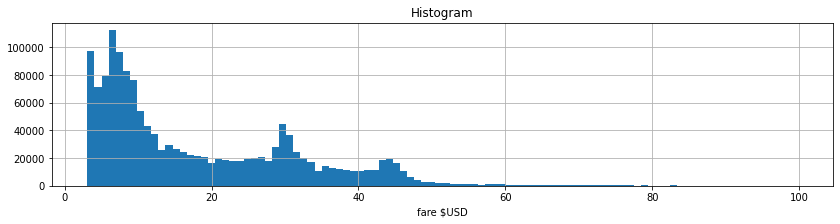

In [366]:
# plot histogram of fare
df_raw[(df_raw.Fare<100) &(df_raw.Fare>3)].Fare.hist(bins=100, figsize=(14,3))
#df_raw.Fare.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram');

In [367]:
print('Old size: %d' % len(df_raw))
df_raw = df_raw[(df_raw.Fare<100) &(df_raw.Fare>3.2) & (df_raw['Trip Seconds']>0) & (df_raw['Trip Miles']) > 0]
print('New size: %d' % len(df_raw))

Old size: 1471174
New size: 1243892


### Draw the GIS related plots
Latitude: 41.878156

Longitude: -87.629309

In [254]:
# minimum and maximum longitude test set
BB_long = [min(df_raw['Pickup Centroid Longitude'].min(), df_raw['Dropoff Centroid Longitude'].min()), \
max(df_raw['Pickup Centroid Longitude'].max(), df_raw['Dropoff Centroid Longitude'].max())]

In [255]:
# minimum and maximum latitude test
BB_lati = [min(df_raw['Pickup Centroid Latitude'].min(), df_raw['Dropoff Centroid Latitude'].min()), \
max(df_raw['Pickup Centroid Latitude'].max(), df_raw['Dropoff Centroid Latitude'].max())]

In [256]:
BB = BB_long + BB_lati
boundary = [(BB[0], BB[2]),
            (BB[0], BB[3]),
            (BB[1], BB[2]),
            (BB[1], BB[3])]
BB

[-87.91362762451172, -87.53490447998047, 41.66013717651367, 42.02122497558594]

#### Get the map boudary from the folium and save as png

In [257]:
# draw the png plot
import folium
df_raw = df_raw.reset_index(drop = True)
chicago_map = folium.Map(location=[41.864073,-87.706819],
                        zoom_start=12,
                        min_lat=BB[2],
                        max_lat=BB[3],
                        min_lon=BB[0],
                        max_lon=BB[1],
                        tiles="OpenStreetMap")
for i in range(len(boundary)):
    lat = boundary[i][1]
    long = boundary[i][0]
    
    folium.CircleMarker(location = [lat, long], fill = True).add_to(chicago_map)
chicago_map

In [258]:
def select_within_boundingbox(df, BB):
    return (df['Pickup Centroid Longitude'] >= BB[0]) & (df['Pickup Centroid Longitude'] <= BB[1]) & \
           (df['Pickup Centroid Latitude'] >= BB[2]) & (df['Pickup Centroid Latitude'] <= BB[3]) & \
           (df['Dropoff Centroid Longitude'] >= BB[0]) & (df['Dropoff Centroid Longitude'] <= BB[1]) & \
           (df['Dropoff Centroid Latitude'] >= BB[2]) & (df['Dropoff Centroid Latitude'] <= BB[3])
            
def plot_hires(df, BB, figsize=(12, 12), ax=None, c=('r', 'b')):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    idx = select_within_boundingbox(df, BB)
    ax.scatter(df[idx]['Pickup Centroid Longitude'], df[idx]['Pickup Centroid Latitude'], c=c[0], s=10, alpha=0.5)
    ax.scatter(df[idx]['Dropoff Centroid Longitude'], df[idx]['Dropoff Centroid Latitude'], c=c[1], s=10, alpha=0.5)

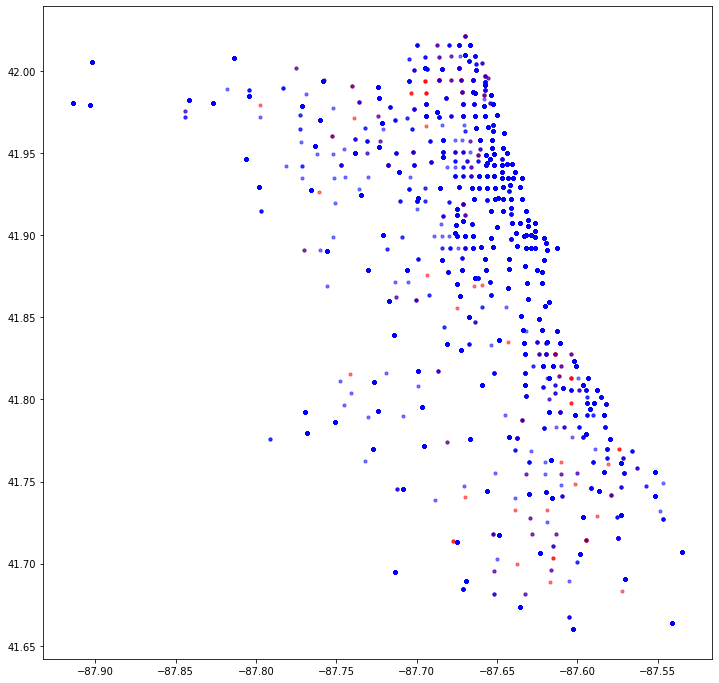

In [259]:
plot_hires(df_raw,BB)

In [260]:
ckg_map = plt.imread('Chicago_map.png')
# this function will be used more often to plot data on the  map
def plot_on_map(df, BB, ckg_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df['Pickup Centroid Longitude'], df['Pickup Centroid Latitude'], zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(ckg_map, zorder=0, extent=BB)

    axs[1].scatter(df['Dropoff Centroid Longitude'], df['Dropoff Centroid Latitude'], zorder=1, alpha=alpha, c='b', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(ckg_map, zorder=0, extent=BB)

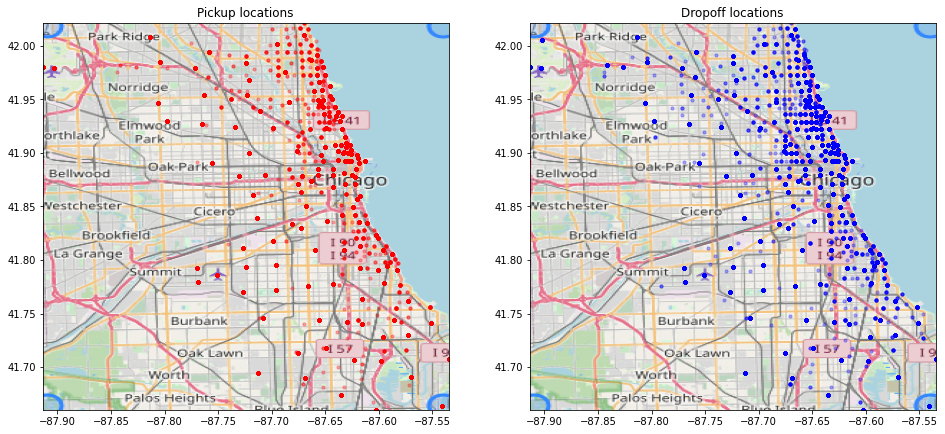

In [261]:
plot_on_map(df_raw, BB, ckg_map, s=10, alpha=0.3)

### Draw the density of pickup and drop off in each area

In [205]:
# For this plot and further analysis, we need a function to calculate the distance in miles between locations in lon,lat coordinates.
# This function is based on https://stackoverflow.com/questions/27928/
# calculate-distance-between-two-latitude-longitude-points-haversine-formula 
# return distance in miles
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...

# First calculate two arrays with datapoint density per sq mile
n_lon, n_lat = 100, 100 # number of grid bins per longitude, latitude dimension
density_pickup, density_dropoff = np.zeros((n_lat, n_lon)), np.zeros((n_lat, n_lon)) # prepare arrays

# To calculate the number of datapoints in a grid area, the numpy.digitize() function is used. 
# This function needs an array with the (location) bins for counting the number of datapoints
# per bin.
bins_lon = np.zeros(n_lon+1) # bin
bins_lat = np.zeros(n_lat+1) # bin
delta_lon = (BB[1]-BB[0]) / n_lon # bin longutide width
delta_lat = (BB[3]-BB[2]) / n_lat # bin latitude height
bin_width_miles = distance(BB[2], BB[1], BB[2], BB[0]) / n_lon # bin width in miles
bin_height_miles = distance(BB[3], BB[0], BB[2], BB[0]) / n_lat # bin height in miles
for i in range(n_lon+1):
    bins_lon[i] = BB[0] + i * delta_lon
for j in range(n_lat+1):
    bins_lat[j] = BB[2] + j * delta_lat
    
# Digitize per longitude, latitude dimension
inds_pickup_lon = np.digitize(df_raw['Pickup Centroid Longitude'], bins_lon)
inds_pickup_lat = np.digitize(df_raw['Pickup Centroid Latitude'], bins_lat)
inds_dropoff_lon = np.digitize(df_raw['Dropoff Centroid Longitude'], bins_lon)
inds_dropoff_lat = np.digitize(df_raw['Dropoff Centroid Latitude'], bins_lat)

# Count per grid bin
# note: as the density_pickup will be displayed as image, the first index is the y-direction, 
#       the second index is the x-direction. Also, the y-direction needs to be reversed for
#       properly displaying (therefore the (n_lat-j) term)
dxdy = bin_width_miles * bin_height_miles
for i in range(n_lon):
    for j in range(n_lat):
        density_pickup[j, i] = np.sum((inds_pickup_lon==i+1) & (inds_pickup_lat==(n_lat-j))) / dxdy
        density_dropoff[j, i] = np.sum((inds_dropoff_lon==i+1) & (inds_dropoff_lat==(n_lat-j))) / dxdy

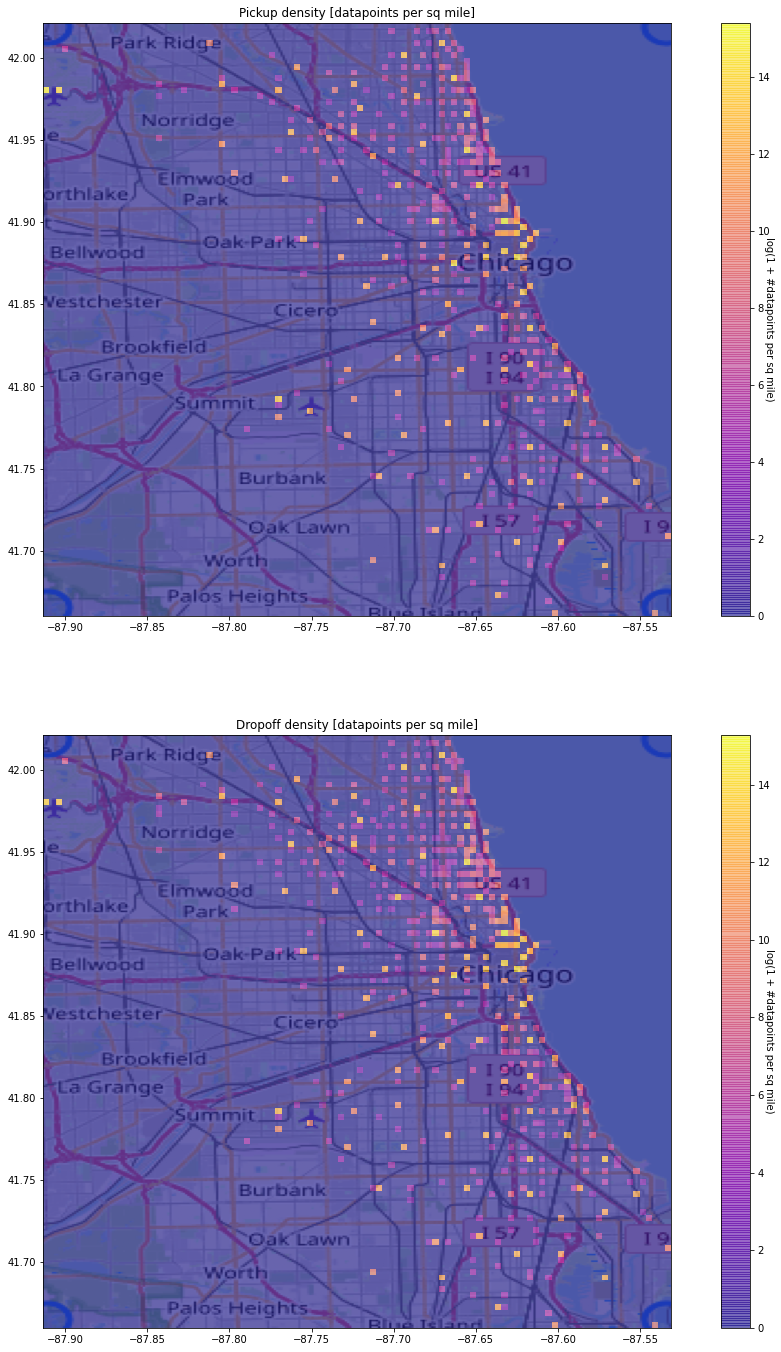

In [210]:
# Plot the density arrays
fig, axs = plt.subplots(2, 1, figsize=(18, 24))
axs[0].imshow(ckg_map, zorder=0, extent=BB);
im = axs[0].imshow(np.log1p(density_pickup), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
axs[0].set_title('Pickup density [datapoints per sq mile]')
cbar = fig.colorbar(im, ax=axs[0])
cbar.set_label('log(1 + #datapoints per sq mile)', rotation=270)

axs[1].imshow(ckg_map, zorder=0, extent=BB);
im = axs[1].imshow(np.log1p(density_dropoff), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
axs[1].set_title('Dropoff density [datapoints per sq mile]')
cbar = fig.colorbar(im, ax=axs[1])
cbar.set_label('log(1 + #datapoints per sq mile)', rotation=270)

In [211]:
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
center_location = [41.864073,-87.706819]
chicago_map_1 = folium.Map(location=center_location,
                        zoom_start=12,
                        control_scale=True,
                        min_lat=BB[2],
                        max_lat=BB[3],
                        min_lon=BB[0],
                        max_lon=BB[1],
                        tiles="OpenStreetMap")
df_raw ["count"] =1
heatmap_data = df_raw.head(1000000)[['Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'count']].groupby(['Pickup Centroid Latitude', 'Pickup Centroid Longitude']).sum().reset_index().values.tolist()
gradient = {0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 0.8: 'red'}
HeatMap(data=heatmap_data, radius=5, gradient=gradient, max_zoom=13).add_to(chicago_map_1)
chicago_map_1

### Draw the trips relationships with different Community Areas

In [212]:
df_area = df_raw.groupby(by=['Pickup Community Area','Dropoff Community Area'])\
      .agg({'Trip ID':'count'}).reset_index().rename(columns ={'Trip ID':'No Trips'})\
      .sort_values(by='No Trips',ascending = False)[:100]

Text(0, 0.5, 'Dropoff Community Area')

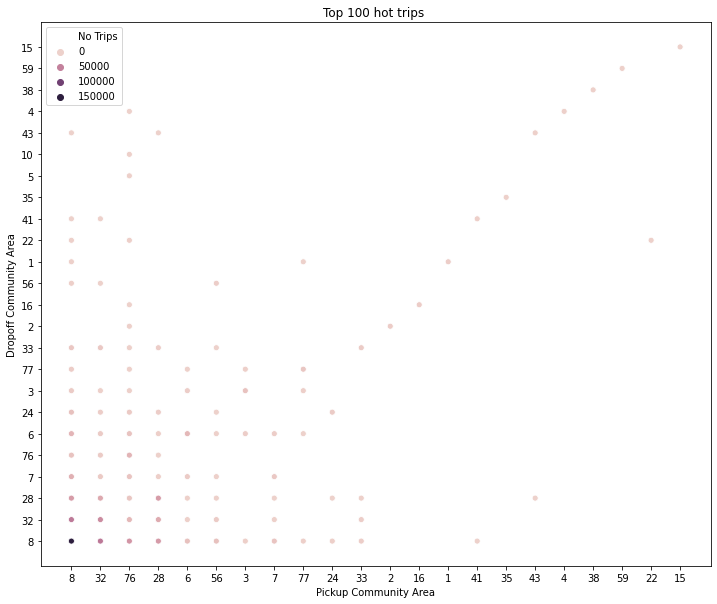

In [213]:
fig, axs = plt.subplots(1, 1, figsize=(12,10))
sns.scatterplot(data=df_area, x="Pickup Community Area", y="Dropoff Community Area", hue="No Trips", ax = axs)

axs.set_title('Top 100 hot trips ')
axs.set_xlabel('Pickup Community Area')
axs.set_ylabel('Dropoff Community Area')

## Draw economic related plots

In [368]:
def extract_time_features(df):
    df["weekday"] = df['Trip Start Timestamp'].apply(lambda x: x.weekday())
    df["hour"] = df['Trip Start Timestamp'].apply(lambda x: x.hour)
    df["month"] =df['Trip Start Timestamp'].apply(lambda x: x.month)
    return df
df_raw = extract_time_features(df_raw)

### Draw company monthly share

<AxesSubplot:ylabel='Share'>

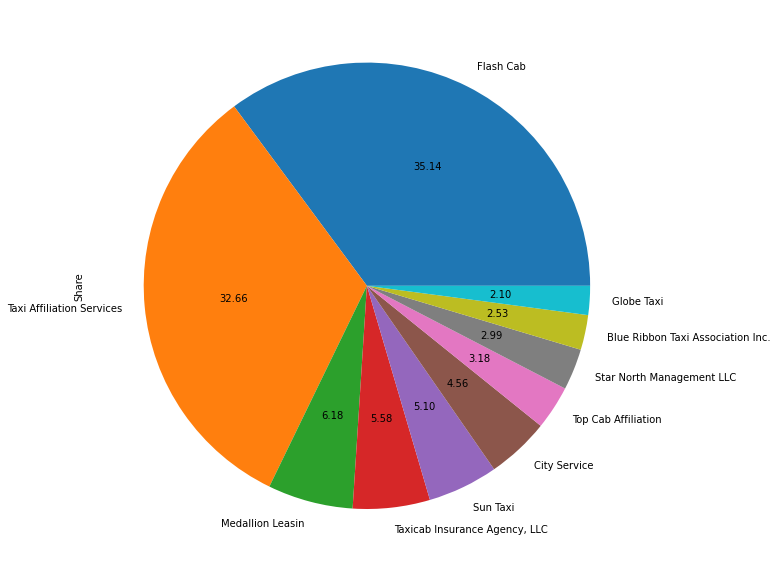

In [237]:
# company renvenue
month_revenues = df_raw[['Fare', 'Company','month']]\
                .groupby(['Company','month'])\
                .sum().reset_index().groupby('Company')\
                .agg({'Fare':'mean'}).rename(columns = {"Fare":'Avg.Monthly Revenues'})
month_revenues['Share'] =  month_revenues['Avg.Monthly Revenues']/sum(month_revenues['Avg.Monthly Revenues']) * 100
month_revenues.sort_values(by='Share',ascending = False)[:10]['Share'].plot.pie(figsize=(10,20), autopct="%.2f")

In [244]:
month_revenues_driver = df_raw[['Fare', 'Taxi ID','month','Trip ID']]\
                .groupby(['Taxi ID','month'])\
                .agg({'Fare':'sum', 'Trip ID': 'count'}).reset_index().groupby('Taxi ID')\
                .agg({'Fare':'mean', 'Trip ID':'mean'}).rename(columns = {"Fare":'Avg.Monthly salary', 
                                                                          'Trip ID':'Avg.Trips count'})
month_revenues_driver['Earning/trips'] =  month_revenues_driver['Avg.Monthly salary']/month_revenues_driver['Avg.Trips count']

### Draw Drivers monthly earnings 

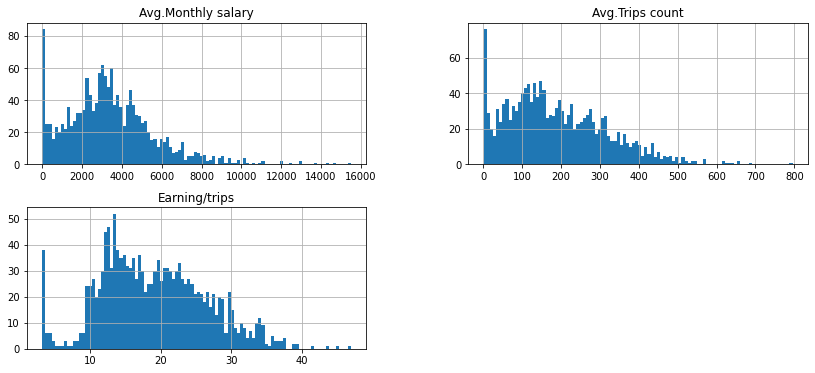

In [245]:
# plot histogram of drivers monthly salary
month_revenues_driver[month_revenues_driver['Avg.Monthly salary']> 0].hist(bins=100, figsize=(14,6))
#df_raw.Fare.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram');

## Draw time related plots

### Animation -- how the pickups numbers and location change according to different hour 

In [248]:
# plot the day hourly changes
heatmap_data_by_hour = []
__data__ = df_raw.head(1200000)
for hour in df_raw.hour.sort_values().unique():
    _data = __data__[__data__.hour == hour][['Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'count']]\
                    .groupby(['Pickup Centroid Latitude', 'Pickup Centroid Longitude']).sum().reset_index().values.tolist()
    heatmap_data_by_hour.append(_data)

chicago_map_2 = folium.Map(location=center_location, control_scale=True, zoom_start=11)
HeatMapWithTime(heatmap_data_by_hour, radius=5, 
                gradient=gradient, 
                min_opacity=0.5, max_opacity=0.8, 
                use_local_extrema=False).add_to(chicago_map_2)
chicago_map_2

### Animation -- how the pickups numbers and location change according to different weekday 

In [250]:
# plot the weekday changes
heatmap_data_by_weekday = []
__data__ = df_raw.head(1200000)
for weekday in df_raw.weekday.sort_values().unique():
    _data = __data__[__data__.weekday == weekday][['Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'count']]\
                    .groupby(['Pickup Centroid Latitude', 'Pickup Centroid Longitude']).sum().reset_index().values.tolist()
    heatmap_data_by_weekday.append(_data)

chicago_map_3 = folium.Map(location=center_location, control_scale=True, zoom_start=11)
HeatMapWithTime(heatmap_data_by_weekday, radius=5, 
                gradient=gradient, 
                min_opacity=0.5, max_opacity=0.8, 
                use_local_extrema=False).add_to(chicago_map_3)
chicago_map_3

## Draw Feature related plot to determine the influencing features

### How the fare changes according to different Trip Miles and Trip Seconds

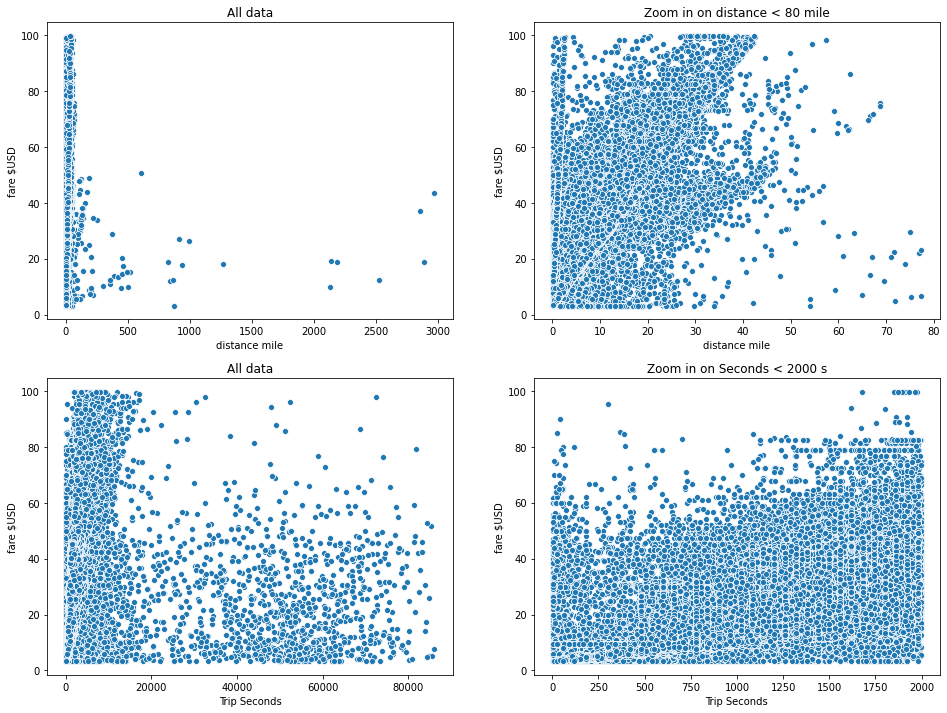

In [271]:
# Correlation between fare and distance
# sns.scatterplot(x="Trip Miles", y="Fare", palette="icefire",data=df_raw[df_raw['Trip Miles'] < 80].sample(100000))
# scatter plot distance - fare
fig, axs = plt.subplots(2, 2, figsize=(16,12))
sns.scatterplot(x="Trip Miles", y="Fare", palette="icefire",data=df_raw, ax =axs[0][0])
axs[0][0].set_xlabel('distance mile')
axs[0][0].set_ylabel('fare $USD')
axs[0][0].set_title('All data')

# zoom in on part of data
sns.scatterplot(x="Trip Miles", y="Fare", palette="icefire",data=df_raw[df_raw['Trip Miles'] < 80], ax =axs[0][1])
axs[0][1].set_xlabel('distance mile')
axs[0][1].set_ylabel('fare $USD')
axs[0][1].set_title('Zoom in on distance < 80 mile');


sns.scatterplot(x="Trip Seconds", y="Fare", palette="icefire",data=df_raw, ax =axs[1][0])
axs[1][0].set_xlabel('Trip Seconds')
axs[1][0].set_ylabel('fare $USD')
axs[1][0].set_title('All data')

# zoom in on part of data
sns.scatterplot(x="Trip Seconds", y="Fare", palette="icefire",data=df_raw[df_raw['Trip Seconds'] < 2000], ax =axs[1][1])
axs[1][1].set_xlabel('Trip Seconds')
axs[1][1].set_ylabel('fare $USD')
axs[1][1].set_title('Zoom in on Seconds < 2000 s');

In [369]:
print('Old size: %d' % len(df_raw))
df_raw = df_raw[df_raw['Trip Miles'] < 80].reset_index(drop= True)
print('New size: %d' % len(df_raw))


Old size: 1243892
New size: 1243800


In [370]:
df_raw['fare_per_mile'] = df_raw['Fare'] / df_raw['Trip Miles']

### How the unit fare changes according to different hours and month (line plot)

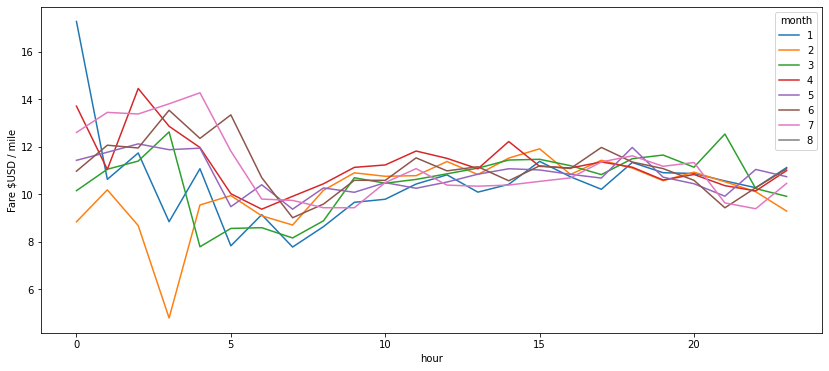

In [302]:
# display pivot table
df_raw.pivot_table('fare_per_mile', index='hour', columns='month').plot(figsize=(14,6))
plt.ylabel('Fare $USD / mile');

### How the fare chanegs according to different direction of the trip (A--> B is different from B--> A)
Relevance of direction for fare amount
Upto now I mainly considered the total distance of a trip as a main feature for predicting the fare amount. However, what about the direction of a trip? To visualise this, I start with a simple plot of the delta longitude and latitude and the fare amount.

In [371]:
df_raw['delta_lon'] = df_raw['Pickup Centroid Longitude'] - df_raw['Dropoff Centroid Longitude']
df_raw['delta_lat'] = df_raw['Pickup Centroid Latitude'] - df_raw['Dropoff Centroid Latitude']

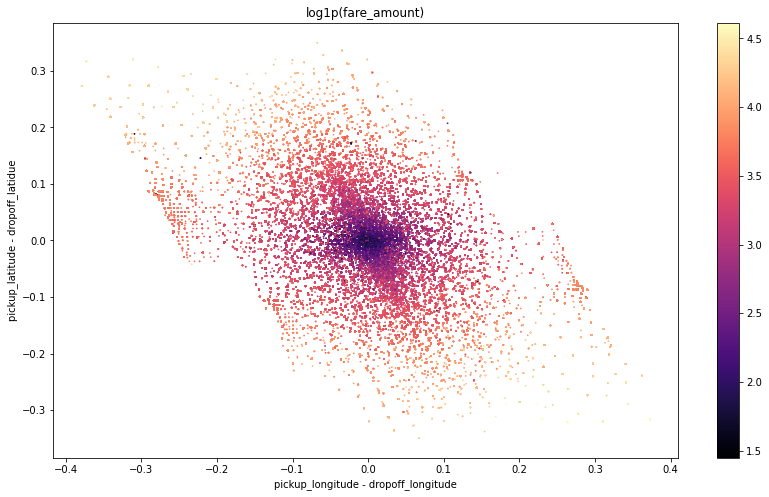

In [343]:

# Select trips in Manhattan

idx_= select_within_boundingbox(df_raw, BB)

plt.figure(figsize=(14,8))
plt.scatter(df_raw[idx_].delta_lon, df_raw[idx_].delta_lat, s=0.5, alpha=1.0, 
            c=np.log1p(df_raw[idx_].Fare), cmap='magma')
plt.colorbar()
plt.xlabel('pickup_longitude - dropoff_longitude')
plt.ylabel('pickup_latitude - dropoff_latidue')
plt.title('log1p(fare_amount)');

In [372]:
# direction of a trip, from 180 to -180 degrees. Horizontal axes = 0 degrees.
def calculate_direction(d_lon, d_lat):
    result = np.zeros(len(d_lon))
    l = np.sqrt(d_lon**2 + d_lat**2)
    result[d_lon>0] = (180/np.pi)*np.arcsin(d_lat[d_lon>0]/l[d_lon>0])
    idx = (d_lon<0) & (d_lat>0)
    result[idx] = 180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])
    idx = (d_lon<0) & (d_lat<0)
    result[idx] = -180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])
    return result

df_raw['direction'] = calculate_direction(df_raw.delta_lon, df_raw.delta_lat)

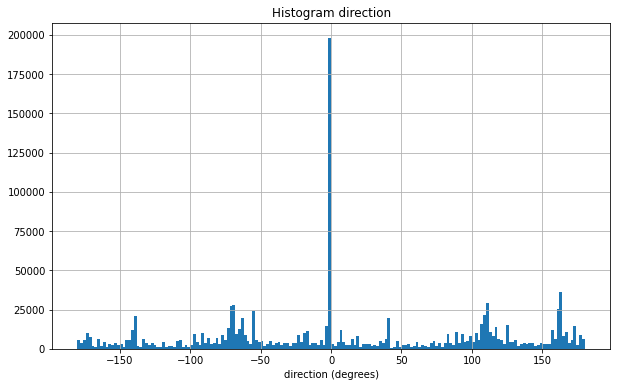

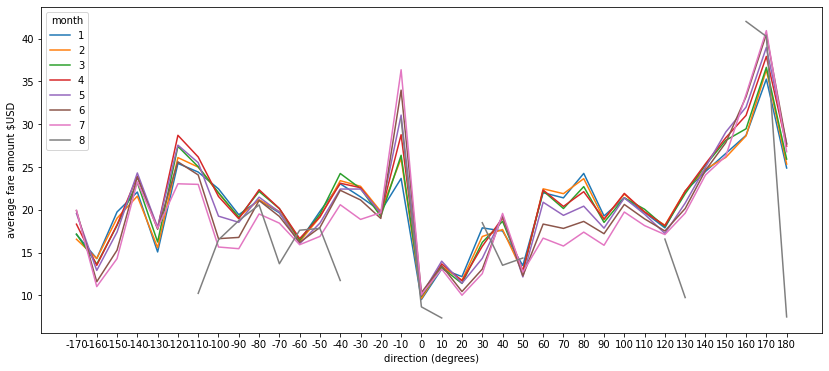

In [346]:


# plot histogram of directions
plt.figure(figsize=(10,6))
df_raw[idx_].direction.hist(bins=180)
plt.xlabel('direction (degrees)')
plt.title('Histogram direction')

# plot direction vs average fare amount
fig, ax = plt.subplots(1, 1, figsize=(14,6))
direc = pd.cut(df_raw[idx_]['direction'], np.linspace(-180, 180, 37))
df_raw[idx_].pivot_table('Fare', index=[direc], columns='month', aggfunc='mean').plot(ax=ax)
plt.xlabel('direction (degrees)')
plt.xticks(range(36), np.arange(-170, 190, 10))
plt.ylabel('average fare amount $USD');

In [ ]:
# create the baseline model for the taxi fare prediction
# based on the website that base = 3.25  additional_mils = 1.4, wait_time = 20/hour
# https://www.taxi-calculator.com/taxi-rate-chicago/261

# Part II

In [294]:
# define some handy analysis support function
from sklearn.metrics import mean_squared_error, explained_variance_score

def plot_prediction_analysis(y, y_pred, figsize=(10,4), title=''):
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    axs[0].scatter(y, y_pred)
    mn = min(np.min(y), np.min(y_pred))
    mx = max(np.max(y), np.max(y_pred))
    axs[0].plot([mn, mx], [mn, mx], c='red')
    axs[0].set_xlabel('$y$')
    axs[0].set_ylabel('$\hat{y}$')
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    evs = explained_variance_score(y, y_pred)
    axs[0].set_title('rmse = {:.2f}, evs = {:.2f}'.format(rmse, evs))
    
    axs[1].hist(y-y_pred, bins=50)
    avg = np.mean(y-y_pred)
    std = np.std(y-y_pred)
    axs[1].set_xlabel('$y - \hat{y}$')
    axs[1].set_title('Histrogram prediction error, $\mu$ = {:.2f}, $\sigma$ = {:.2f}'.format(avg, std))
    
    if title!='':
        fig.suptitle(title)

## Using the website taix fare calculation approach as the the benchmark model for comparison

In [373]:
df_raw['Bench_mark_Fair'] = df_raw['Trip Miles'].apply(lambda x: x*1.4 + 3.25)

In [347]:
# create training and test sets
from sklearn.model_selection import train_test_split

features = ['month', 'hour', 'weekday', 'Trip Seconds', 'Trip Miles','direction']
X = df_raw[features].values
y = df_raw['Fare'].values
y_bench = df_raw['Bench_mark_Fair'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

 **Linear model 1**
 $$
    \text{fare} \text{ ~ } \text{month}, \text{hour}, \text{weekday}, \text{Trip Miles}, \text{Trip Seconds}, \text{direction}
 $$

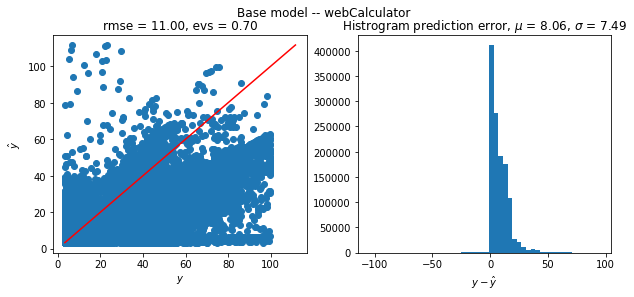

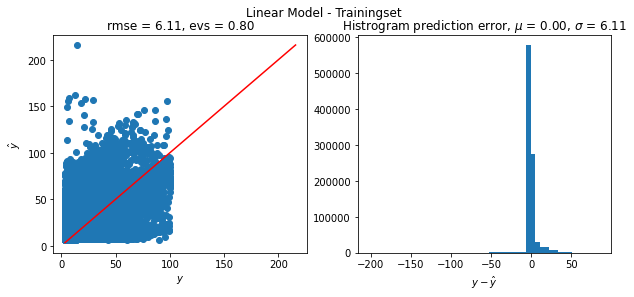

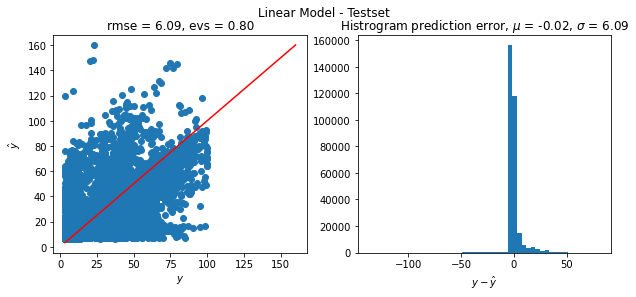

In [297]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

model_lin = Pipeline((
        ("standard_scaler", StandardScaler()),
        ("lin_reg", LinearRegression()),
    ))
model_lin.fit(X_train, y_train)

plot_prediction_analysis(y, y_bench, title='Base model -- webCalculator')

y_train_pred = model_lin.predict(X_train)
plot_prediction_analysis(y_train, y_train_pred, title='Linear Model - Trainingset')

y_test_pred = model_lin.predict(X_test)
plot_prediction_analysis(y_test, y_test_pred, title='Linear Model - Testset')

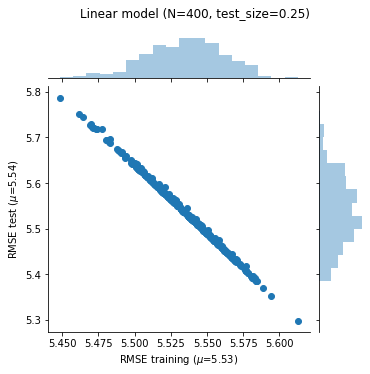

In [282]:
# some handy function to see how sensitive the model is to the selection
# of the training and test set
def plot_rmse_analysis(model, X, y, N=400, test_size=0.25, figsize=(10,4), title=''):
    rmse_train, rmse_test = [], []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        rmse_train.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
        rmse_test.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

    g = sns.jointplot(np.array(rmse_train), np.array(rmse_test), kind='scatter', stat_func=None, size=5)
    g.set_axis_labels("RMSE training ($\mu$={:.2f})".format(np.mean(rmse_train)), 
                      "RMSE test ($\mu$={:.2f})".format(np.mean(rmse_test)))
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle('{} (N={}, test_size={:0.2f})'.format(title, N, test_size))
    
# only 100k points are used to shorten calculation time
plot_rmse_analysis(model_lin, X[:100_000,:], y[:100_000], title='Linear model')

  **Linear Model 2**
    $$
    \text{fare} \text{ ~ } \text{month}, \text{hour}, \text{weekday}, \text{PickupCommunityArea}, \text{DropoffCommunityArea}, \text{direction}, \text{Distance}
    $$

In [374]:
# using geo distance + direction to predict trip mile, 
df_raw['Distance'] = distance(df_raw['Pickup Centroid Latitude'], df_raw['Pickup Centroid Longitude'], \
                              df_raw['Dropoff Centroid Latitude'], df_raw['Dropoff Centroid Longitude'])
df_raw.rename(columns ={'Pickup Community Area':'PickupCommunityArea',
                        'Dropoff Community Area': 'DropoffCommunityArea'}, inplace = True)

In [308]:
features = ['Distance', 'direction', 'month', 'hour', 'weekday','PickupCommunityArea','DropoffCommunityArea']
X = df_raw[features].values
y = df_raw['Fare'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [310]:
pre_model_1 = Pipeline((
        ("standard_scaler", StandardScaler()),
        ("lin_reg", LinearRegression()),
    ))
pre_model_1.fit(X_train, y_train)

Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('lin_reg', LinearRegression())])

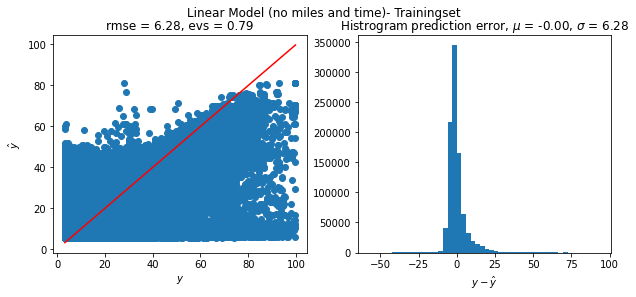

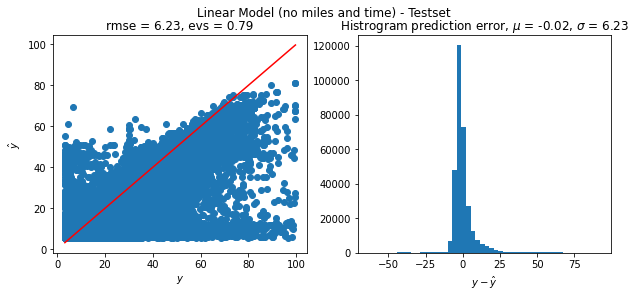

In [311]:
y_train_pred = pre_model_1.predict(X_train)
plot_prediction_analysis(y_train, y_train_pred, title='Linear Model (no miles and time)- Trainingset')

y_test_pred = pre_model_1.predict(X_test)
plot_prediction_analysis(y_test, y_test_pred, title='Linear Model (no miles and time) - Testset')

**Linear Model 3**
    $$
    \text{fare} \text{ ~ } \text{month}, \text{hour}, \text{weekday}, \text{PickupCommunityArea}, \text{DropoffCommunityArea}, \text{direction}, \text{Distance}, \text{tmpf}, \text{dwpf}, \text{relh},  \text{sknt}
    $$

- tmpf:
  Air Temperature in Fahrenheit, typically @ 2 meters
- dwpf:
  Dew Point Temperature in Fahrenheit, typically @ 2 meters
- relh:
  Relative Humidity in %
- drct:
  Wind Direction in degrees from *true* north
- sknt:
  Wind Speed in knots

In [380]:
# adding the new weather data as the addition feature to see wether it helps
df_weather = pd.read_csv('Weather_data.csv',delimiter=',',
                         parse_dates=["valid"])[['valid','tmpf','dwpf','relh','sknt']].dropna(axis = 1, how ='all')
df_weather['weather_time'] = df_weather['valid'].dt.round('H')

for col in ['tmpf','dwpf','relh','sknt']:
    df_weather[col] = df_weather[col].interpolate(method='nearest')
    
df_weather = df_weather.groupby(by = 'weather_time').agg({'tmpf':'mean','dwpf':'mean', 'relh':'mean','sknt':'mean'}).reset_index()
df_raw['weather_time'] = df_raw['Trip Start Timestamp'].dt.round('H')  
df_raw_weather = df_raw.merge(df_weather, how='left', on='weather_time').dropna()
df_raw_weather.head()                

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,PickupCommunityArea,DropoffCommunityArea,Fare,Payment Type,...,delta_lon,delta_lat,direction,Bench_mark_Fair,Distance,weather_time,tmpf,dwpf,relh,sknt
0,4bcfcfa78f372b705214ee2cba9c765ad6ba5161,31261f6e7fc645eff98c7964c7ea71a0ea7e387a6bd7f8...,2021-01-01,2021-01-01 00:00:00,120.0,0.10,8,8,3.50,Cash,...,0.000000,0.000000,0.000000,3.390,0.000000,2021-01-01,16.9,14.7,90.88,0.0
1,7b7b8108de94a518607068a7369ceea1ab2ae924,2c508057a94474215bdea7b101edad0dc911ef61bb99e6...,2021-01-01,2021-01-01 00:00:00,50.0,0.38,60,31,4.00,Cash,...,0.018784,-0.014114,-36.921988,3.782,1.373249,2021-01-01,16.9,14.7,90.88,0.0
2,855259d1bc129f6370f038aa910067972eeae037,0aba795cd29b34ff868043bc923a341f37c4f6d7afabe4...,2021-01-01,2021-01-01 00:15:00,900.0,0.30,28,22,18.25,Cash,...,0.035637,-0.048756,-53.835858,3.670,3.834973,2021-01-01,16.9,14.7,90.88,0.0
3,88194fab0a0a28df1b87e9f358143197d004d4d9,e11ecc8e74a2d3cbd2e9f58151ed09c81587cb491c50f6...,2021-01-01,2021-01-01 00:15:00,1140.0,4.30,6,4,15.25,Cash,...,0.031517,-0.030945,-44.475135,9.270,2.682079,2021-01-01,16.9,14.7,90.88,0.0
4,a76c9cae097af5ff1dfef35b376a832f54d789ea,72920f6ebc5830d39039323cf78a316085444eb8f8b272...,2021-01-01,2021-01-01 00:30:00,1800.0,9.80,8,68,29.00,Cash,...,0.009186,0.122406,85.708328,16.970,8.470646,2021-01-01,16.9,14.7,90.88,0.0


In [382]:
print('Old size: %d' % len(df_raw))
print('New size: %d' % len(df_raw_weather))

Old size: 1243800
New size: 1209878


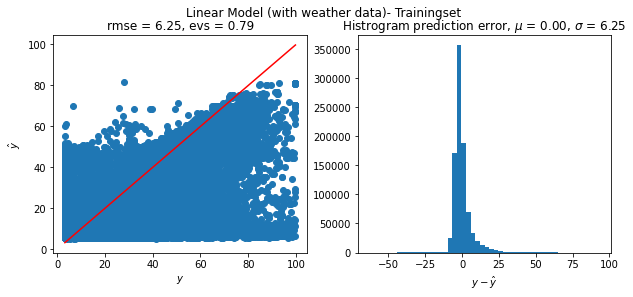

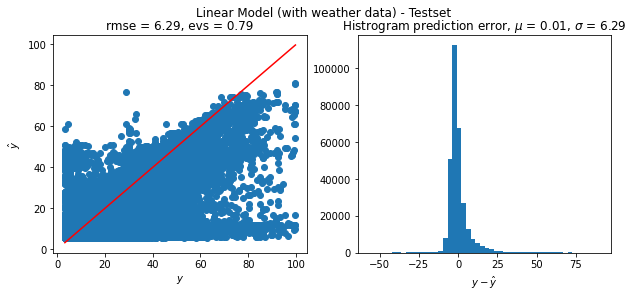

In [383]:
features = ['Distance', 'direction', 'month', 'hour', 'weekday','PickupCommunityArea','DropoffCommunityArea', 'tmpf',
            'dwpf', 'relh', 'sknt']
X = df_raw_weather[features].values
y = df_raw_weather['Fare'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

pre_model_2 = Pipeline((
        ("standard_scaler", StandardScaler()),
        ("lin_reg", LinearRegression()),
    ))
pre_model_2.fit(X_train, y_train)

y_train_pred = pre_model_2.predict(X_train)
plot_prediction_analysis(y_train, y_train_pred, title='Linear Model (with weather data)- Trainingset')

y_test_pred = pre_model_2.predict(X_test)
plot_prediction_analysis(y_test, y_test_pred, title='Linear Model (with weather data) - Testset')

  **Linear Model 4**
   $$
    \text{fare} \text{ ~ } \text{month}, \text{hour}, \text{weekday}, \text{Pickup Centroid Latitude}, \text{Pickup Centroid Longitude}, \text{Dropoff Centroid Latitude}, \text{Dropoff Centroid Longitude},\text{direction}, \text{Distance}, \text{tmpf}, \text{dwpf}, \text{relh},  \text{sknt}
    $$

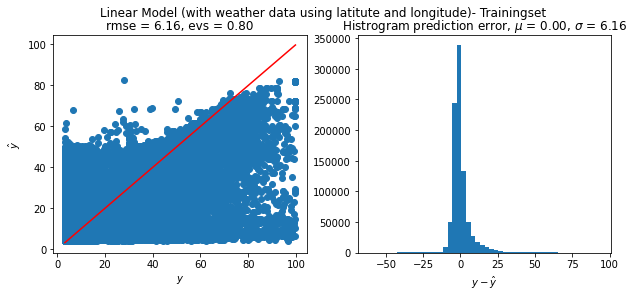

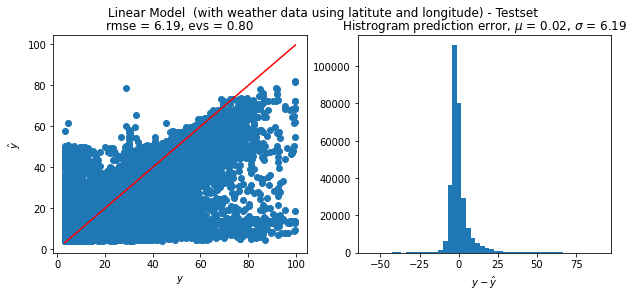

In [386]:
features = ['Distance', 'direction', 'month', 'hour', 'weekday','Pickup Centroid Latitude','Pickup Centroid Longitude',
            'Dropoff Centroid Latitude','Dropoff Centroid Longitude','tmpf',  'dwpf', 'relh', 'sknt']
            
X = df_raw_weather[features].values
y = df_raw_weather['Fare'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

pre_model_3 = Pipeline((
        ("standard_scaler", StandardScaler()),
        ("lin_reg", LinearRegression()),
    ))
pre_model_3.fit(X_train, y_train)

y_train_pred = pre_model_3.predict(X_train)
plot_prediction_analysis(y_train, y_train_pred, title='Linear Model (with weather data using latitute and longitude)- Trainingset')

y_test_pred = pre_model_3.predict(X_test)
plot_prediction_analysis(y_test, y_test_pred, title='Linear Model  (with weather data using latitute and longitude) - Testset')

**RandomForestRegressor**
    $$
    \text{fare} \text{ ~ } \text{month}, \text{hour}, \text{weekday}, \text{Pickup Centroid Latitude}, \text{Pickup Centroid Longitude}, \text{Dropoff Centroid Latitude}, \text{Dropoff Centroid Longitude},\text{direction}, \text{Distance}, \text{tmpf}, \text{dwpf}, \text{relh},  \text{sknt}
    $$

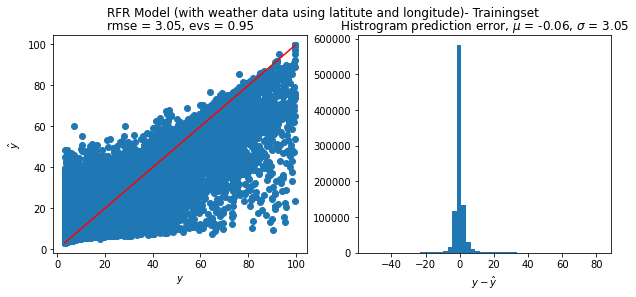

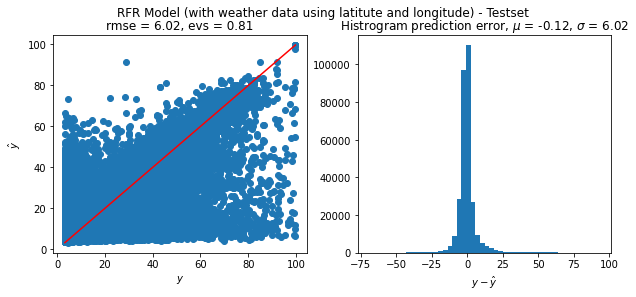

In [388]:
# using different models for the prediction
from sklearn.ensemble import RandomForestRegressor
# rf = RandomForestRegressor()
# rf.fit(x_train, y_train)
features = ['Distance', 'direction', 'month', 'hour', 'weekday','Pickup Centroid Latitude','Pickup Centroid Longitude',
            'Dropoff Centroid Latitude','Dropoff Centroid Longitude','tmpf',  'dwpf', 'relh', 'sknt']
            
X = df_raw_weather[features].values
y = df_raw_weather['Fare'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

pre_model_4 = Pipeline((
        ("standard_scaler", StandardScaler()),
        ("RFR_reg", RandomForestRegressor()),
    ))
pre_model_4.fit(X_train, y_train)

y_train_pred = pre_model_4.predict(X_train)
plot_prediction_analysis(y_train, y_train_pred, title='RFR Model (with weather data using latitute and longitude)- Trainingset')

y_test_pred = pre_model_4.predict(X_test)
plot_prediction_analysis(y_test, y_test_pred, title='RFR Model (with weather data using latitute and longitude) - Testset')

**In conclusion**, the last RFR with the coorinates and weather data shows the best evs and rmse, therefore, we use the last model as our final one.

**Future work**: need to try the another regression model to see weather the performance is furture improved